In [1]:
from qdrant_client import QdrantClient

client = QdrantClient(url="http://localhost:6333")



In [2]:
import torch
from anomalib.models import  EfficientAd ,Patchcore
from torchvision.transforms import ToTensor
from PIL import Image
from anomalib.data import MVTec
from anomalib.engine import Engine
# Load pre-trained models


/home/wzy/anamalib/.venv/lib/python3.12/site-packages/kornia/feature/lightglue.py:44: FutureWarning: `torch.cuda.amp.custom_fwd(args...)` is deprecated. Please use `torch.amp.custom_fwd(args..., device_type='cuda')` instead.
  @torch.cuda.amp.custom_fwd(cast_inputs=torch.float32)


In [3]:
patchcore_model = Patchcore().eval()

In [ ]:
from anomalib.models.components.feature_extractors import TimmFeatureExtractor

FeatureExtractor = TimmFeatureExtractor(backbone='wide_resnet50_2', layers=['act1','layer1','layer2','layer3','layer4'])##default backbone of Patchcore in anomalib ,use API from anomalib to make it easier
input = torch.rand((32, 3, 256, 256))

features = FeatureExtractor(input)

print([feature.shape for feature in features.values()]) 

[torch.Size([32, 64, 128, 128]), torch.Size([32, 256, 64, 64]), torch.Size([32, 512, 32, 32]), torch.Size([32, 1024, 16, 16]), torch.Size([32, 2048, 8, 8])]


In [ ]:
datamodule = MVTec(category='tile')
model = Patchcore()
engine = Engine(max_epochs=5)

In [ ]:
res=engine.predict(model=model,data_path ='./datasets/MVTec/tile/test/') ##the original training data only contains negative(normal) samples, so I just extract features from test set using engine.predict the dataset is automatically download if performed a training on MVTec dataset

ckpt_path is not provided. Model weights will not be loaded.
F1Score class exists for backwards compatibility. It will be removed in v1.1. Please use BinaryF1Score from torchmetrics instead
F1Score class exists for backwards compatibility. It will be removed in v1.1. Please use BinaryF1Score from torchmetrics instead
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/home/wzy/anamalib/.venv/lib/python3.12/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:424: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=23` in the `DataLoader` to improve performance.


Predicting: |          | 0/? [00:00<?, ?it/s]

In [ ]:
def extract_features(model, image_path,layername):
    image_path = image_path[0]
    img = Image.open(image_path).convert('RGB')
    img = img.resize((256,256))
    img_tensor = ToTensor()(img).unsqueeze(0)  # Add batch dimension
    with torch.no_grad():
        features = model(img_tensor)  # Extract features
    return features[layername].numpy()
##somehow the original dataset is 840*840 and needs processing , this function process the image and output its feature

In [ ]:
from qdrant_client.models import PointStruct

path = []
index = []

client.recreate_collection(
    collection_name="test_collection",
    vectors_config=VectorParams(size=64, distance=Distance.COSINE),
)


for i in range(len(res)):
    if res[i]['pred_labels'] == True:
        index.append(i)
        path.append(res[i]['image_path'])
        tmp = extract_features(FeatureExtractor,res[i]['image_path'],'layer4')
        tmp=tmp.squeeze()
        tmp = np.sum(tmp, axis=0) ##stack the dimensions to form a feature vector short enough to be stored in qdrant
        tmp = tmp.reshape(64)
        client.upsert(
        collection_name="test_collection",
        points=[PointStruct(id=i, vector=tmp)])

/tmp/ipykernel_1508/3898408993.py:6: DeprecationWarning: `recreate_collection` method is deprecated and will be removed in the future. Use `collection_exists` to check collection existence and `create_collection` instead.
  client.recreate_collection(


In [ ]:
tmp = extract_features(FeatureExtractor,path[0],'layer4') ##for easiness I just used the first sample 
tmp=tmp.squeeze()
tmp = np.sum(tmp, axis=0) ##stack the dimensions to form a feature vector short enough to be stored in qdrant
tmp = tmp.reshape(64)

In [ ]:
search_result = client.query_points(
    collection_name="test_collection",
    query=tmp,
    with_payload=False,
    limit=6 ##excluding itself 
).points #query 

In [173]:
print(search_result)

[ScoredPoint(id=0, version=0, score=0.99999994, payload=None, vector=None, shard_key=None, order_value=None), ScoredPoint(id=25, version=25, score=0.9257101, payload=None, vector=None, shard_key=None, order_value=None), ScoredPoint(id=90, version=55, score=0.9009794, payload=None, vector=None, shard_key=None, order_value=None), ScoredPoint(id=85, version=50, score=0.8648875, payload=None, vector=None, shard_key=None, order_value=None), ScoredPoint(id=24, version=24, score=0.8303823, payload=None, vector=None, shard_key=None, order_value=None), ScoredPoint(id=22, version=22, score=0.80576295, payload=None, vector=None, shard_key=None, order_value=None)]


['/home/wzy/anamalib/datasets/MVTec/tile/test/glue_strip/008.png']


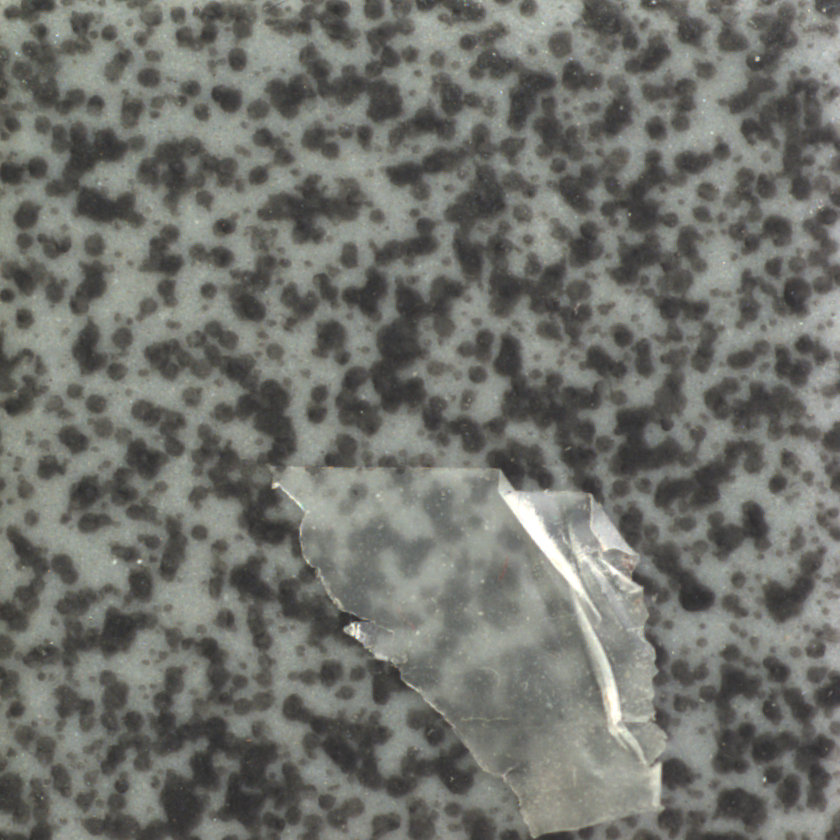

In [ ]:
print(res[search_result[1].id]['image_path'])
path0 = res[search_result[1].id]['image_path'][0]
img = Image.open(path0).convert('RGB')
img.show()